# Activity recognition on the Capture24 dataset -- Convolutional neural networks

*This section assumes familiarity with [PyTorch](https://pytorch.org/)*

In this section, instead of using the hand-crafted features, we use a neural network on the raw accelerometer measurements so that we let the neural network automatically learn relevant features for classification.

Setup:

In [1]:
import numpy as np
from scipy.ndimage import median_filter
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from tqdm import tqdm
import utils

# For reproducibility
np.random.seed(42)
torch.manual_seed(42)
cudnn.benchmark = True

 Load dataset and hold out some instances for testing: 

In [2]:
# X_raw = np.memmap('X_raw.dat', dtype='float32', mode='r').reshape(-1,3,3000)
X_raw = np.load('/tmp/X_raw_small.npy')
print("Raw data shape:", X_raw.shape)
# data = np.load('capture24.npz', allow_pickle=True)
data = np.load('/tmp/capture24_small.npz', allow_pickle=True)
print("Data contents:", data.files)
y, pid, time = data['y'], data['pid'], data['time']

# Hold out some participants for testing the model
test_pids = [2, 3]
test_mask = np.isin(pid, test_pids)
train_mask = ~np.isin(pid, test_pids)
X_train, y_train, pid_train = X_raw[train_mask], y[train_mask], pid[train_mask]
X_test, y_test, pid_test = X_raw[test_mask], y[test_mask], pid[test_mask]
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

Raw data shape: (11016, 3, 3000)
Data contents: ['X_feats', 'y', 'pid', 'time', 'annotation']
Shape of X_train: (6025, 3, 3000)
Shape of X_test: (4991, 3, 3000)


A standard procedure is to normalize the input data, which aids the optimization of neural networks:

In [3]:
scaler = preprocessing.StandardScaler(copy=False)
X_train = scaler.fit_transform(X_train.reshape(X_train.shape[0],-1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(X_test.shape[0],-1)).reshape(X_test.shape)

We start by defining a simple feed-forward convolutional neural network (CNN):

In [4]:
class CNN(nn.Module):
    def __init__(self, output_dim, in_channels, num_filters_base=8):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels, num_filters_base,
                8, 4, 2, bias=False),  # state shape (N,num_filters_base,750)
            nn.BatchNorm1d(num_filters_base),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base, num_filters_base*2,
                6, 4, 2, bias=False),  # state shape (N,num_filters_base*2,188)
            nn.BatchNorm1d(num_filters_base*2),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*2, num_filters_base*4,
                8, 4, 2, bias=False),  # state shape (N,num_filters_base*4,47)
            nn.BatchNorm1d(num_filters_base*4),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*4, num_filters_base*8,
                3, 2, 1, bias=False),  # state shape (N,num_filters_base*8,24)
            nn.BatchNorm1d(num_filters_base*8),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*8, num_filters_base*16,
                4, 2, 1, bias=False),  # state shape (N,num_filters_base*16,12)
            nn.BatchNorm1d(num_filters_base*16),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*16, num_filters_base*32,
                4, 2, 1, bias=False),  # state shape (N,num_filters_base*32,6)
            nn.BatchNorm1d(num_filters_base*32),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*32, num_filters_base*64,
                6, 1, 0, bias=False),  # state shape (N,num_filters_base*64,1)
            nn.BatchNorm1d(num_filters_base*64),
            nn.ReLU(True),
            nn.Conv1d(num_filters_base*64, output_dim,
                1, 1, 0, bias=True)  # state shape (N,output_dim,1)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm1d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.cnn(x).squeeze()

### Setup GPU device

 If there is a GPU, let's use it! 

In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    # torch.cuda.set_device(args.device)
    print("Using {} device: {}".format(device, torch.cuda.current_device()))
else:
    device = torch.device("cpu")
    print("Using {}".format(device))

Using cuda device: 0


 Define a dataset iterator that will provide the mini-batches during the training, instantiate the neural network, and define the loss function and optimizer: 

In [6]:
max_iter = 10
lr = 1e-4
num_filters_base = 8
batch_size = 32

X_train_torch = torch.from_numpy(X_train.astype('float32')).to(device)
y_train_torch = torch.from_numpy(y_train).to(device)
def create_dataloader(batch_size=1):
    nbatch = X_train_torch.shape[0] // batch_size
    idxs = np.random.permutation(np.arange(X_train_torch.shape[0]))
    for i in range(nbatch):
        _idxs = idxs[i:i+batch_size]
        yield X_train_torch[_idxs], y_train_torch[_idxs]

cnn = CNN(
    output_dim=utils.NUM_CLASSES,
    in_channels=X_train_torch.shape[1],
    num_filters_base=num_filters_base
).to(device)
print(cnn)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=lr, amsgrad=True)

CNN(
  (cnn): Sequential(
    (0): Conv1d(3, 8, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
    (1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv1d(8, 16, kernel_size=(6,), stride=(4,), padding=(2,), bias=False)
    (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv1d(16, 32, kernel_size=(8,), stride=(4,), padding=(2,), bias=False)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv1d(32, 64, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (10): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Conv1d(64, 128, kernel_size=(4,), stride=(2,), padding=(1,), bias=False)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): 

### Begin training via use of GPU device

 Training via mini-batch gradient descent begins here. We loop through the training set `max_iter` times with the `dataloader` iterator.

100%|██████████| 10/10 [00:08<00:00,  1.20it/s]


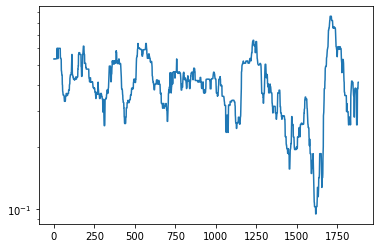

In [7]:
losses = []
for i in tqdm(range(max_iter)):
    dataloader = create_dataloader(batch_size)
    for x, y in dataloader:
        cnn.zero_grad()
        output = cnn(x)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

# View loss during training
utils.plt.semilogy(median_filter(losses, size=100))
utils.plt.savefig('cnn_loss.png')

### Evaluation

 Evaluate the model on the hold out set 

In [8]:
cnn.eval()
with torch.no_grad():
    output = cnn(torch.from_numpy(X_test.astype('float32')).to(device))
    y_test_pred = torch.argmax(F.softmax(output, dim=1), dim=1).cpu().numpy()
print("Cohen kappa score:", utils.cohen_kappa_score(y_test, y_test_pred, pid_test))
print("Accuracy score:", utils.accuracy_score(y_test, y_test_pred, pid_test))

#TODO: HMM smoothing


Cohen kappa score: 0.5350294252991195
Accuracy score: 0.7263124986043188
